<a href="https://colab.research.google.com/github/mahiidharv/Demonstration-of-Different-Optimizers-on-Autoencoders/blob/master/mask_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.1.0
!pip install ipynb

     |████████████████████████████████| 421.8MB 36kB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 3.9MB 43.0MB/s 
     |████████████████████████████████| 450kB 32.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=449e8fd452d4c568465f1298b33d46991441d4c6c78968a0394828e6d859f5a5
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')

In [ ]:
physical_devices

[]

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
os.chdir('/content/drive/MyDrive/YoloV3')

In [ ]:
!ls

 functions.py.txt	      mask_prediction.ipynb   sims.npy
 images			      masks.npy		      yolo.py
 iom.npy		      model.h5		      yolov3_Prediction.ipynb
'mask_prediction (1).ipynb'   __pycache__	      yolov3.weights


In [ ]:
import numpy as np

In [ ]:
from tensorflow.keras.models import load_model
# load yolov3 model
model = load_model(r'model.h5')

In [ ]:
iom = np.load('iom.npy')

In [ ]:
def reshape_img(x):
    x = x.reshape((1,416,416,3))
    return x

In [ ]:
X = list(map(reshape_img,iom))

In [ ]:
from tqdm import tqdm
outputs=list(map(model.predict,tqdm(X)))

100%|██████████| 1000/1000 [22:20<00:00,  1.34s/it]


In [ ]:
len(outputs)

1000

In [ ]:
Yhat_batch={}
for i,x in enumerate(outputs):
    Yhat_batch[i]=x

In [ ]:
import numpy as np
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
 
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1
 
    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
 
        return self.label
 
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score
 
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): continue
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
 
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0
 
 
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores

In [ ]:

def get_dp(yhat,anchors,class_threshold):
 
    boxes = list()
    for i in range(len(yhat)):
      boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
    # correct the sizes of the bounding boxes for the shape of the image
    correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
    # suppress non-maximal boxes
    do_nms(boxes, 0.5)
    # define the labels
    labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
     # get the details of the detected objects
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
    # summarize what we found
    dt = []    
    for i in range(len(v_boxes)):
        box = v_boxes[i]      
        #print((box.xmin,box.ymin,box.xmax,box.ymax,box.objness,list(box.classes)))
        dt.append((box.xmin,box.ymin,box.xmax,box.ymax,box.objness,list(box.classes)))

    return dt





In [ ]:
[print(a.shape) for a in Yhat_batch[0]]

(1, 13, 13, 255)
(1, 26, 26, 255)
(1, 52, 52, 255)


[None, None, None]

In [125]:
from numpy import expand_dims
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
 
# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

input_w, input_h = 416, 416
class_threshold = 0.6
photo_filename = r'images/surfboard.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

In [ ]:
input_w, input_h = 416, 416
class_threshold = 0.6
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]


In [ ]:
input_w, input_h = 416, 416
class_threshold = 0.6
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
dp={}
for k,v in tqdm(Yhat_batch.items()):
   dp[k] = get_dp(v,anchors,class_threshold)

100%|██████████| 1000/1000 [1:18:56<00:00,  4.74s/it]


In [31]:
dp[0]

[(47,
  38,
  105,
  126,
  0.99753857,
  [0.9975038,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0]),
 (41,
  100,
  180,
  154,
  0.9013384,
  [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,


In [32]:
np.save('dp.npy',dp)

In [33]:
len(dp.keys())

1000

In [34]:
 
# define the expected input shape for the model

input_w, input_h = 416, 416
# define our new photo
photo_filename = r'images/surfboard.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])
di = get_dp(yhat,anchors,class_threshold)

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


In [35]:
# Selecting the surfboard to be the class
di_Person = di[0]

In [36]:
di_Person

(48,
 38,
 106,
 126,
 0.9979869,
 [0.9979541,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0])

xmin,ymin.xmax,ymax = 0,1,2,3

In [37]:
def IOU(box1,box2):
    intersect_w = _interval_overlap([box1[0], box1[2]], [box2[0], box2[2]])
    intersect_h = _interval_overlap([box1[1], box1[3]], [box2[1], box2[3]])
    intersect = intersect_w * intersect_h
    w1, h1 = box1[2]-box1[0], box1[3]-box1[1]
    w2, h2 = box2[2]-box2[0], box2[3]-box2[1]
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union


In [38]:
from numpy import dot
from numpy.linalg import norm

In [39]:
def cos_similarity(P1,P2):
    
    cos_sim = dot(P1, P2)/(norm(P1)*norm(P2))
    return cos_sim

In [42]:
def simliarityMetric(di,dp):
    box1 = di[0:4]
    P1 = di[5]
    o1 = di[4] 
    if o1 > 0.99:
        o1 = 1
    sims = {}
    for k in dp.keys():
        sim_=[]
        for j in dp[k]:
            print(j)
            try:
                box2 = j[0:4]
                print(box2)
                P2 = j[5]
                o2 = j[4]
                s1 = IOU(box1,box2)
                print(s1)
                s2 = cos_similarity(P1,P2)
                print(s2)
                s3 = o2
                print(s3)
                sim = s1 * s2 * s3
                print(sim)
                sim_.append(sim)
            except Exception as e:
                sim=0.0
                sim_.append(sim)
        try:
            sims[k] = max(sim_) 
        except Exception as e:
            sims[k] = 0.0
    return sims


In [43]:
sims = simliarityMetric(di_Person,dp)

Streaming output truncated to the last 5000 lines.
0.9989812
0.9765321625752394
(54, 97, 170, 156, 0.9388461, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.93446213, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
(54, 97, 170, 156)
0.14444444444444443
0.0
0.9388461
0.0
(51, 35, 104, 129, 0.98604935, [0.9839616, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [44]:
sims

{0: 0.9637236999253095,
 1: 0.3835199177265167,
 2: 0.9431414381399492,
 3: 0.9406949772360576,
 4: 0.9410617592566439,
 5: 0.9548144097436018,
 6: 0.6245740264841008,
 7: 0.9431005588797635,
 8: 0.8489958372815696,
 9: 0.8900888911423965,
 10: 0.9333690482676481,
 11: 0.6311768113539137,
 12: 0.9639013470229456,
 13: 0.0,
 14: 0.9412121486888037,
 15: 0.9803612992681305,
 16: 0.9494623242057331,
 17: 0.947730589605191,
 18: 0.6938855080021585,
 19: 0.9791815003444408,
 20: 0.964679741723971,
 21: 0.9516406059265137,
 22: 0.6819880169387148,
 23: 0.6364236600393411,
 24: 0.7689727754337546,
 25: 0.0,
 26: 0.7107289455433998,
 27: 0.0,
 28: 0.7247736991783107,
 29: 0.9305273033795313,
 30: 0.9694956592595411,
 31: 0.9459561036027772,
 32: 0.8944043247467112,
 33: 0.9300868771970272,
 34: 0.958729749561964,
 35: 0.5444637697692202,
 36: 0.9680849950088593,
 37: 0.9710740688304017,
 38: 0.9301565092783876,
 39: 0.5243894385128486,
 40: 0.6221918195345932,
 41: 0.9805590551474999,
 42: 0.9

In [45]:
np.save('sims.npy',sims)

In [46]:
masks = np.load('masks.npy')

In [47]:
masks_list =[]
for x in masks:
  x = x.reshape((1,416,416,1))
  x = np.squeeze(x)
  masks_list.append(x)

In [48]:
masks_list[0]

array([[1.        , 1.        , 1.        , ..., 0.99572706, 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.99572706, 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.99572706, 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.99698704, 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.99691397, 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.99684095, 1.        ,
        1.        ]], dtype=float32)

In [49]:
masks_list[0].shape

(416, 416)

In [64]:
sum = np.zeros((416,416))
for i,m in enumerate(masks_list):
    sum = sum + m * sims[i]


In [91]:
sum 

array([[579.185068  , 579.24143925, 579.29932659, ..., 592.36951846,
        592.56791405, 592.73705922],
       [579.07170797, 579.1300629 , 579.1901983 , ..., 592.45294827,
        592.65334093, 592.82515074],
       [578.95124515, 579.01220065, 579.075171  , ..., 592.56306259,
        592.76479602, 592.93861222],
       ...,
       [580.71999465, 580.69395765, 580.635666  , ..., 597.02474911,
        596.70486136, 596.38821664],
       [580.48836942, 580.46179669, 580.40205146, ..., 597.51519707,
        597.20063222, 596.88852064],
       [580.31530609, 580.28815521, 580.22691373, ..., 597.99236099,
        597.6829666 , 597.37521908]])

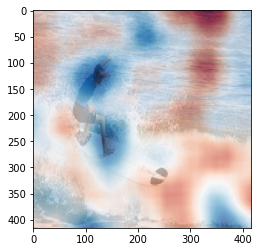

In [139]:
from matplotlib import pyplot as plt
plt.imshow(np.squeeze(image))
plt.imshow(sum,cmap='RdBu',alpha=0.7)

In [120]:
di_surfboard = di[1]
sims_surfboard = simliarityMetric(di_surfboard,dp)

Streaming output truncated to the last 5000 lines.
0.9989812
0.0
(54, 97, 170, 156, 0.9388461, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.93446213, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
(54, 97, 170, 156)
0.6631344116006692
1.0
0.9388461
0.6225811635989154
(51, 35, 104, 129, 0.98604935, [0.9839616, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [121]:
sum_surfboard = np.zeros((416,416))
for i,m in enumerate(masks_list):
    sum_surfboard = sum_surfboard + m * sims_surfboard[i]

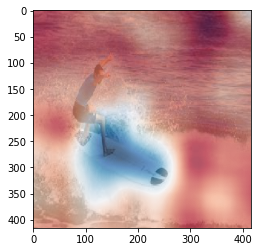

In [140]:
plt.imshow(np.squeeze(image))
plt.imshow(sum_surfboard,cmap='RdBu',alpha=0.7)

In [151]:
def heatmap_smoothing(image_path,heatmap):
    og_img = cv2.imread(image_path)
    resize_list = og_img.shape
    heatmap = cv2.resize(heatmap, (resize_list[0],resize_list[1])) # Resizing
    og_img = cv2.resize(og_img, (resize_list[0],resize_list[1])) # Resizing
    '''
    The minimum pixel value will be mapped to the minimum output value (alpha - 0)
    The maximum pixel value will be mapped to the maximum output value (beta - 155)
    Linear scaling is applied to everything in between.
    These values were chosen with trial and error using COLORMAP_JET to deliver the best pixel saturation for forming contours.
    '''
    heatmapshow = cv2.normalize(heatmap, None, alpha=0, beta=155, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    heatmapshow = cv2.applyColorMap(heatmapshow, cv2.COLORMAP_JET)
    return og_img, heatmapshow

In [174]:
og_img, heatmap_surfboard = heatmap_smoothing(photo_filename,sum_surfboard)

In [154]:
def form_bboxes(smooth_heatmap,scale_list):
    grey_img = cv2.cvtColor(smooth_heatmap, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(grey_img,127,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)

    for item in range(len(contours)):
        cnt = contours[item]
        if len(cnt)>20:
            #print(len(cnt))
            x,y,w,h = cv2.boundingRect(cnt) # x, y is the top left corner, and w, h are the width and height respectively
            poly_coords = [cnt] # polygon coordinates are based on contours
            
            x = int(x*scale_list[0]) # rescaling the boundary box based on user input
            y = int(y*scale_list[1])
            w = int(w*scale_list[2])
            h = int(h*scale_list[3])

            return [x,y,w,h], poly_coords, grey_img, contours
        
        else: print("contour error (too small)")

In [170]:
 def show_bboxpolygon(og_img,poly_coords):
        cv2.polylines(og_img,poly_coords,True,(0,0,0),2)
        cv2_imshow(og_img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

In [175]:
[x,y,w,h], poly_coords, grey_img, contours = form_bboxes(heatmap_surfboard,scale_list=[1,1,1,1])

In [167]:
 def show_bboxrectangle(og_img,bbox_coords,smoothed_heatmap):
    cv2.rectangle(og_img,
                    (bbox_coords[0],bbox_coords[1]),
                    (bbox_coords[0]+bbox_coords[2],bbox_coords[1]+bbox_coords[3]),
                    (0,0,0),3)
    cv2_imshow(og_img)
    cv2_imshow(smoothed_heatmap)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

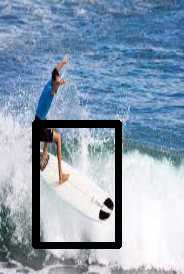

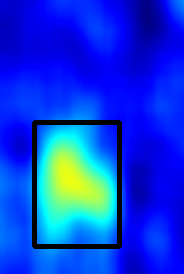

In [169]:
show_bboxrectangle(og_img=og_img,smoothed_heatmap = heatmap_surfboard,bbox_coords=[x,y,w,h])

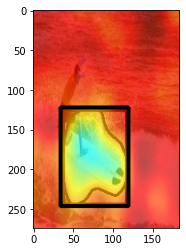

In [172]:
plt.imshow(og_img)
plt.imshow(heatmap_surfboard,alpha=0.7)

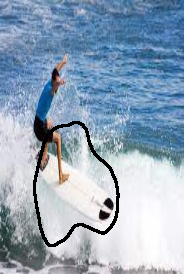

In [176]:
show_bboxpolygon(og_img,poly_coords)